Let's start by generating some triangles! This also defines the `calculate_surface` function, based on [Heron's formula](https://en.wikipedia.org/wiki/Heron%27s_formula). This formula can be re-written in many forms. In here it is written as:

$A = \sqrt{p (p - a) (p - b) (p - c)}$

$p \equiv \frac{a + b + c}{2}$

where $a$, $b$, $c$ are the side lenghts of the triangle, and $A$ is the surface. As the $\sqrt{x}$ is imaginary for negative $x$, we instead save the square of the surface to our dataset, called `surf2` here.

In [1]:
import numpy as np
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option("display.max_rows", 10)
num_triangles = 10000

def generate_triangle(min_surf=1, maxiter=1000, plot=False, scale=10):
    surf = 0
    ii = 0
    while surf < 1:
        coords = scale * np.random.rand(3, 2)
        AB = coords[0, :] - coords[1, :]
        BC = coords[1, :] - coords[2, :]
        CA = coords[2, :] - coords[0, :]
        surf = 0.5 * np.cross(AB, BC)
        edges = np.vstack([AB, BC, CA])

        a, b, c = np.linalg.norm(edges, 2, axis=1)
        surf2 = calculate_surface((a, b, c))
        if ii > maxiter:
            warn('Did not find sufficient surface triangle')
            break
        ii += 1
    if plot:
        polygon = Polygon(coords[:,:], True, fc='b')
    else:
        polygon = None
    return ((a, b, c), polygon)

def calculate_surface(edges):
    """ Heron's formula """
    a, b, c = edges
    p = (a + b + c) / 2
    surf = np.sqrt(p * (p - a) * (p - b) * (p - c))
    return surf

data = []
patches = []
plot = False
scale = 10
for i in range(num_triangles):
    (edges, polygon) = generate_triangle(plot=plot, scale=scale)
    a, b, c = edges
    surf = calculate_surface(edges)
    if plot:
        patches.append(polygon)
    data.append((a, b, c, surf))

if plot:
    fig, ax = plt.subplots()
    p = PatchCollection(patches, alpha=.4)
    colors = 100*np.random.rand(len(patches))
    p.set_array(np.array(colors))
    ax.add_collection(p)
    plt.ylim([0, scale])
    plt.xlim([0, scale])
    fig.colorbar(p, ax=ax)
    plt.show()

data = pd.DataFrame(data, columns=['a', 'b', 'c', 'surf'])
data['surf2'] = data['surf'] ** 2
data.drop('surf', axis=1, inplace=True)
data

a         b         c       surf2
0      8.775003  7.708216  2.015391   48.906310
1     10.029697  6.550424  7.167545  548.595378
2      9.072346  9.486113  1.012014   18.306436
3      8.094550  7.230513  5.804065  414.167163
4      0.760265  4.114697  4.548319    1.815082
...         ...       ...       ...         ...
9995   4.657779  4.701998  7.022075  118.017344
9996   3.422125  6.202433  7.950577  102.018268
9997   3.587988  2.623148  4.112281   21.640195
9998   3.849414  1.660623  3.477243    8.335839
9999   5.069860  9.384073  8.281332  438.268636

[10000 rows x 4 columns]

Next, we'll define some functions that will build the Neural Network we're going to train. Note that this is very much work in process! I've currently defined three functions:

- `ml_style_net`. This one shows a standard Machine Learning approach when the underlying function is unknown (as it usally is in ML problems.
- `ml_style_analytical_net`. This function show a hybrid ML/classical approach. We know the analytical function has powers of 4 of our inputs, so we define a net with two hidden layers and a square activation function. Our function is thus:

$
o_0 =
\left(
\left(
\left[ \begin{array}{ccc}
i_0 & i_1 & i_2
\end{array} \right]
*
\left[ \begin{array}{ccc}
w_{00} & w_{01} & w_{02} \\
w_{10} & w_{11} & w_{12} \\
w_{20} & w_{21} & w_{22} \\
\end{array} \right]
%+
%\left[ \begin{array}{ccc}
%b_0 & b_1 & b_2
%\end{array} \right]
\right)^2
*
\left[ \begin{array}{cc}
w_{00} & w_{01} \\
w_{10} & w_{11} \\
w_{20} & w_{21} \\
\end{array} \right]
%+
%\left[ \begin{array}{cc}
%b_0 & b_1
%\end{array} \right]
\right)^2
\left[ \begin{array}{c}
w_{00} \\
w_{10} \\
\end{array} \right]
%+b_0
$

- `vianney_style_analytical_net`. With this function we cheat a bit. We already know the underlying function, so we just initialize our net as a random pertubation of this function:

$
o_0 =
\left(
\left(
\left[ \begin{array}{ccc}
i_0 & i_1 & i_2
\end{array} \right]
*
\left[ \begin{array}{ccc}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1
\end{array} \right]
\right)^2
*
\left[ \begin{array}{cccc}
1 & 1 & 0 & 0 \\
1 & 0 & 1 & 0 \\
1 & 0 & 0 & 1
\end{array} \right]
\right)^2
\left[ \begin{array}{c}
1/16 & -1/8 & -1/8 & - 1/8
\end{array} \right]
$

All these function use the [Keras](https://keras.io/) package for the model definitions.

In [2]:
from pprint import pprint

from keras.models import Sequential
import tensorflow as tf

def ml_style_net():
    model = Sequential()
    winit = 'random_uniform'
    binit = 'zeros'
    model.add(Dense(30, activation='relu', input_shape=(x_train.shape[1],),
                    bias_initializer=binit, kernel_initializer=winit))
    model.add(Dense(30, activation='relu', bias_initializer=binit, kernel_initializer=winit))
    model.add(Dense(1, activation='linear', input_shape=(2,), bias_initializer=binit, kernel_initializer=winit))
    return model

def ml_style_analytical_net():
    model = Sequential()
    use_bias = False
    #winit = keras.initializers.RandomNormal(mean=.5, stddev=0.05, seed=None)
    #binit = keras.initializers.Zeros()
    winit = 'random_uniform'
    binit = 'zeros'
    model.add(Dense(3, activation=tf.square, input_shape=(x_train.shape[1],), use_bias=use_bias,
                    bias_initializer=binit, kernel_initializer=winit))
    model.add(Dense(2, activation=tf.square, input_shape=(3,), use_bias=use_bias, bias_initializer=binit, kernel_initializer=winit))
    model.add(Dense(1, activation='linear', input_shape=(2,), use_bias=use_bias, bias_initializer=binit, kernel_initializer=winit))
    
    return model

def vianney_style_analytical_net_layers(verbose=False, perturb=0.01):
    layers = []
    layers.append(np.eye(3))
    layers.append(np.hstack([np.ones((3,1)), np.eye(3)]))
    layers.append(np.array([[1/16], [-1/8], [-1/8], [-1/8]]))
    for ii in range(len(layers)):
        layers[ii] = layers[ii]        
        if verbose:
            pprint(layer)

    return layers

def vianney_style_analytical_net_init(shape, dtype=None):
    layers = vianney_style_analytical_net_layers()
    linit = None
    if shape == (3, 3):
        linit = layers[0]
    elif shape == (3, 4):
        linit = layers[1]
    elif shape == (4, 1):
        linit = layers[2]
    assert linit.shape == shape, 'generated ' + str(linit.shape) + ' is not requested ' + str(shape)
    return linit

def vianney_style_analytical_net():
    model = Sequential()
    use_bias = False
    binit = 'zeros'
    winit = vianney_style_analytical_net_init

    model.add(Dense(3, activation=tf.square, input_shape=(x_train.shape[1],), use_bias=use_bias,
                    bias_initializer=binit, kernel_initializer=winit))
    model.add(Dense(4, activation=tf.square, input_shape=(3,), use_bias=use_bias, bias_initializer=binit, kernel_initializer=winit))
    model.add(Dense(1, activation='linear', input_shape=(4,), use_bias=use_bias, bias_initializer=binit, kernel_initializer=winit))
    return model

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Now, prepare the dataset for training in Keras. We are splitting the `features` (or inputs) of our dataset from the `targets` (or ourputs). Also, we split our dataset in two, the `test` set and the `training` set. Finally we define what to optimize, in other words, the loss function. In this case we use RMS error. Finally, we use the [adam](https://keras.io/optimizers/#adam) as our Steepest Gradient Descend algorithm. (Unfortunately I could not get 'pure' SGD to work). You can uncomment on of `model =` lines to use one of the other models defined in the previous cell. When changing the model you should probably also chance the amount of `epochs` used in training.

The initialzed model is plotted using our own custom-made `draw_neural_net` function, which can be found in the `drawing.py` file.

9000 train samples
1000 test samples


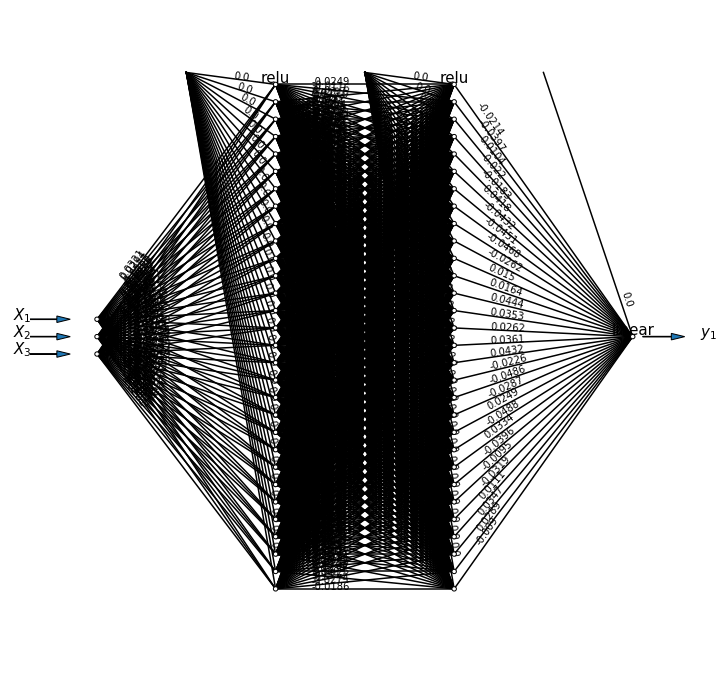

In [3]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras import optimizers

import tensorflow as tf

from drawing import draw_neural_net
from pprint import pprint

batch_size = 10
epochs = 1000
plot_nn = True

# the data, split between train and test sets
data = data.sample(frac=1)
train_frac = 0.9
train_idx = int(train_frac * len(data))

x_train = data.iloc[:train_idx, :-1]
y_train = data.iloc[:train_idx, -1]
x_test = data.iloc[train_idx:, :-1]
y_test = data.iloc[train_idx:, -1]

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

#model = ml_style_analytical_net()
model = ml_style_net()
#model = vianney_style_analytical_net()
#model.summary()
#opt = RMSprop(lr=0.0001)
opt = 'adam'
model.compile(loss='mean_squared_error',
              optimizer=opt)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               min_delta=0.01,
                                               patience=50,
                                               verbose=0,
                                               mode='auto')


# Extract the weights and biases of the model we just defined
weights = [layer.get_weights()[0] for layer in model.layers]
#pprint(weights)
try:
    biases = [layer.get_weights()[1] for layer in model.layers]
    #pprint(biases)
    bplot = True
except IndexError:
    biases = None
    bplot = False
sizes = [len(weight) for weight in weights]
#pprint(sizes)
# Extract the names of the activation functions of the different layers
names = [str(layer.activation).split()[1] for layer in model.layers]
names.insert(0, '')
#pprint(names)

# Finally, define a matplotlib figure and plot the NN!
if plot_nn:
    fig = plt.figure(figsize=(12, 12))
    ax = fig.gca()
    ax.axis('off')
    draw_neural_net(ax, .1, .9, .1, .9, weights, biases, np.inf, np.inf, names, plot_biases=bplot)

    plt.show()

Now that our model is defined, we can start the training! Note that this is running on a cheap VM, so it might be quite slow.. Sorry!

In [4]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=[early_stopping]
                    )
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score)

Train on 9000 samples, validate on 1000 samples
Epoch 1/1000
9000/9000 [==============================] - 1s 122us/step - loss: 28752.4117 - val_loss: 24903.9212
Epoch 2/1000
9000/9000 [==============================] - 1s 106us/step - loss: 24467.4302 - val_loss: 24334.4052
Epoch 3/1000
9000/9000 [==============================] - 1s 106us/step - loss: 23845.0233 - val_loss: 23658.4820
Epoch 4/1000
9000/9000 [==============================] - 1s 107us/step - loss: 23113.7640 - val_loss: 22869.7853
Epoch 5/1000
9000/9000 [==============================] - 1s 106us/step - loss: 21967.1150 - val_loss: 21542.9513
Epoch 6/1000
9000/9000 [==============================] - 1s 107us/step - loss: 20458.6929 - val_loss: 19525.3068
Epoch 7/1000
9000/9000 [==============================] - 1s 105us/step - loss: 18407.2164 - val_loss: 17295.6855
Epoch 8/1000
9000/9000 [==============================] - 1s 105us/step - loss: 16347.7480 - val_loss: 15413.9413
Epoch 9/1000
9000/9000 [================

Epoch 73/1000
9000/9000 [==============================] - 1s 109us/step - loss: 930.3474 - val_loss: 972.4394
Epoch 74/1000
9000/9000 [==============================] - 1s 109us/step - loss: 954.7735 - val_loss: 1079.4833
Epoch 75/1000
9000/9000 [==============================] - 1s 109us/step - loss: 923.2181 - val_loss: 969.9783
Epoch 76/1000
9000/9000 [==============================] - 1s 109us/step - loss: 925.6165 - val_loss: 974.4812
Epoch 77/1000
9000/9000 [==============================] - 1s 109us/step - loss: 900.9859 - val_loss: 1330.1571
Epoch 78/1000
9000/9000 [==============================] - 1s 110us/step - loss: 865.7878 - val_loss: 980.8520
Epoch 79/1000
9000/9000 [==============================] - 1s 109us/step - loss: 846.1220 - val_loss: 911.7084
Epoch 80/1000
9000/9000 [==============================] - 1s 109us/step - loss: 828.7385 - val_loss: 875.3172
Epoch 81/1000
9000/9000 [==============================] - 1s 110us/step - loss: 810.1128 - val_loss: 860.9644

9000/9000 [==============================] - 1s 117us/step - loss: 534.7447 - val_loss: 494.6974
Epoch 147/1000
9000/9000 [==============================] - 1s 107us/step - loss: 518.1589 - val_loss: 547.1628
Epoch 148/1000
9000/9000 [==============================] - 1s 107us/step - loss: 504.6645 - val_loss: 496.5901
Epoch 149/1000
9000/9000 [==============================] - 1s 106us/step - loss: 499.4380 - val_loss: 492.9902
Epoch 150/1000
9000/9000 [==============================] - 1s 107us/step - loss: 510.3192 - val_loss: 511.7441
Epoch 151/1000
9000/9000 [==============================] - 1s 107us/step - loss: 495.9460 - val_loss: 542.5133
Epoch 152/1000
9000/9000 [==============================] - 1s 107us/step - loss: 505.7208 - val_loss: 780.5967
Epoch 153/1000
9000/9000 [==============================] - 1s 107us/step - loss: 520.4671 - val_loss: 561.6372
Epoch 154/1000
9000/9000 [==============================] - 1s 107us/step - loss: 503.9350 - val_loss: 727.9017
Epoch 1

9000/9000 [==============================] - 1s 108us/step - loss: 437.4651 - val_loss: 420.9635
Epoch 220/1000
9000/9000 [==============================] - 1s 108us/step - loss: 428.4782 - val_loss: 473.6632
Epoch 221/1000
9000/9000 [==============================] - 1s 110us/step - loss: 430.9518 - val_loss: 412.7776
Epoch 222/1000
9000/9000 [==============================] - 1s 105us/step - loss: 421.8887 - val_loss: 412.8620
Epoch 223/1000
9000/9000 [==============================] - 1s 108us/step - loss: 443.7211 - val_loss: 399.1012
Epoch 224/1000
9000/9000 [==============================] - 1s 109us/step - loss: 417.1235 - val_loss: 397.5963
Epoch 225/1000
9000/9000 [==============================] - 1s 106us/step - loss: 426.3056 - val_loss: 429.6208
Epoch 226/1000
9000/9000 [==============================] - 1s 105us/step - loss: 418.5204 - val_loss: 475.5156
Epoch 227/1000
9000/9000 [==============================] - 1s 106us/step - loss: 418.1917 - val_loss: 453.2250
Epoch 2

9000/9000 [==============================] - 1s 131us/step - loss: 408.9889 - val_loss: 381.3086
Epoch 293/1000
9000/9000 [==============================] - 1s 132us/step - loss: 374.1363 - val_loss: 330.5349
Epoch 294/1000
9000/9000 [==============================] - 1s 117us/step - loss: 387.2592 - val_loss: 357.6793
Epoch 295/1000
9000/9000 [==============================] - 1s 116us/step - loss: 376.5164 - val_loss: 333.5105
Epoch 296/1000
9000/9000 [==============================] - 1s 115us/step - loss: 383.8669 - val_loss: 387.8109
Epoch 297/1000
9000/9000 [==============================] - 1s 115us/step - loss: 381.7286 - val_loss: 361.3585
Epoch 298/1000
9000/9000 [==============================] - 1s 115us/step - loss: 383.7985 - val_loss: 329.5927
Epoch 299/1000
9000/9000 [==============================] - 1s 111us/step - loss: 375.4193 - val_loss: 322.9672
Epoch 300/1000
9000/9000 [==============================] - 1s 115us/step - loss: 384.7760 - val_loss: 318.5585
Epoch 3

9000/9000 [==============================] - 1s 111us/step - loss: 303.3506 - val_loss: 240.0160
Epoch 366/1000
9000/9000 [==============================] - 1s 110us/step - loss: 298.2028 - val_loss: 253.5495
Epoch 367/1000
9000/9000 [==============================] - 1s 115us/step - loss: 299.8566 - val_loss: 275.3794
Epoch 368/1000
9000/9000 [==============================] - 1s 108us/step - loss: 292.6334 - val_loss: 248.7831
Epoch 369/1000
9000/9000 [==============================] - 1s 108us/step - loss: 291.7218 - val_loss: 250.8979
Epoch 370/1000
9000/9000 [==============================] - 1s 106us/step - loss: 286.6888 - val_loss: 256.6318
Epoch 371/1000
9000/9000 [==============================] - 1s 106us/step - loss: 279.5707 - val_loss: 268.1169
Epoch 372/1000
9000/9000 [==============================] - 1s 108us/step - loss: 292.4715 - val_loss: 242.3562
Epoch 373/1000
9000/9000 [==============================] - 1s 106us/step - loss: 285.8998 - val_loss: 234.2751
Epoch 3

9000/9000 [==============================] - 1s 108us/step - loss: 251.5251 - val_loss: 243.3091
Epoch 439/1000
9000/9000 [==============================] - 1s 110us/step - loss: 245.5003 - val_loss: 247.2275
Epoch 440/1000
9000/9000 [==============================] - 1s 107us/step - loss: 256.8726 - val_loss: 275.8919
Epoch 441/1000
9000/9000 [==============================] - 1s 110us/step - loss: 246.3148 - val_loss: 219.4629
Epoch 442/1000
9000/9000 [==============================] - 1s 109us/step - loss: 250.2872 - val_loss: 336.8189
Epoch 443/1000
9000/9000 [==============================] - 1s 108us/step - loss: 257.6135 - val_loss: 302.1415
Epoch 444/1000
9000/9000 [==============================] - 1s 108us/step - loss: 235.5867 - val_loss: 220.4450
Epoch 445/1000
9000/9000 [==============================] - 1s 110us/step - loss: 241.0384 - val_loss: 330.4409
Epoch 446/1000
9000/9000 [==============================] - 1s 111us/step - loss: 244.1549 - val_loss: 246.6323
Epoch 4

After the our network has finished training, we can see how well it performs. Run the cell below a few times, and compare the analytical result with the one predicted by the Neural Network.

In [5]:
edges, __ = generate_triangle()

print('analytical:', calculate_surface(edges))
print('NN        :', np.sqrt(np.max([model.predict(np.array([edges])), 0])))

analytical: 9.577411691499881
NN        : [[6.3434625]]


Everything below this cell is extremely experimental and probably not working!

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
from keras.models import model_from_json
import tensorflow as tf

json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json, custom_objects={'square': tf.square, 'vianney_style_analytical_net_init': vianney_style_analytical_net_init})

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
%load_ext autoreload
%autoreload 2
%aimport drawing
from drawing import draw_neural_net
from pprint import pprint
weights = [layer.get_weights()[0] for layer in model.layers]; pprint(weights)
try:
    biases = [layer.get_weights()[1] for layer in model.layers]; pprint(biases)
    bplot = True
except IndexError:
    biases = None
    bplot = False
sizes = [len(weight) for weight in weights]; pprint(sizes)
names = [str(layer.activation).split()[1] for layer in model.layers]
names.append('')

fig = plt.figure(figsize=(12, 12))
ax = fig.gca()
ax.axis('off')
draw_neural_net(ax, .1, .9, .1, .9, weights, biases, np.inf, np.inf, names, plot_biases=bplot)

w0 = np.array([[.6,0,-1],[.6, 0, 1],[0, -1.1, 0]]); pprint(w0)
w1 = np.array([[.6,.6],[.4, -.75],[-.64, 0.64]]); pprint(w1)
w2 = np.array([[-.57],[.57]]); pprint(w2)
w3 = np.array([[-0.3]])
plt.show()

$
o_0 =
\left(
\left(
\left[ \begin{array}{ccc}
i_0 & i_1 & i_2
\end{array} \right]
*
\left[ \begin{array}{ccc}
w_{00} & w_{01} & w_{02} \\
w_{10} & w_{11} & w_{12} \\
w_{20} & w_{21} & w_{22} \\
\end{array} \right]
%+
%\left[ \begin{array}{ccc}
%b_0 & b_1 & b_2
%\end{array} \right]
\right)^2
*
\left[ \begin{array}{cc}
w_{00} & w_{01} \\
w_{10} & w_{11} \\
w_{20} & w_{21} \\
\end{array} \right]
%+
%\left[ \begin{array}{cc}
%b_0 & b_1
%\end{array} \right]
\right)^2
\left[ \begin{array}{c}
w_{00} \\
w_{10} \\
\end{array} \right]
%+b_0
$

$o_0 = 4 \left(i_0^2 i_1^2 + i_0^2 i_2^2 + i_1^2 i_2^2 \right) - \left( i_0^2 + i_1^2 + i_2^2 \right)^2$

In [ ]:
def my_net_init(shape, dtype=None):
    w0 = np.array([[.5,0,-1],[.5, 0, 1],[0, -1, 0]]); pprint(w0)
    w1 = np.array([[.5,.5],[1/3, -2/3],[-.6, 0.6]]); pprint(w1)
    w2 = np.array([[-.5],[.5]]); pprint(w2)
    w3 = np.array([[-0.3]])
    if shape == (3, 3):
        return w0
    elif shape == (3, 2):
        return w1
    elif shape == (2, 1):
        return w2
    elif shape == (1, 2):
        return w3

In [ ]:
weights = [layer for layer in vianney_style_analytical_net_layers()]
#out_approx = lambda inp: np.matmul(np.matmul(np.matmul(np.matmul(inp, w0)**2, w1)**2, w2), w3)
out_nn = lambda inp: np.matmul(np.matmul(np.matmul(np.matmul(inp, weights[0])**2, weights[1])**2, weights[2]), weights[3])
out_nn = lambda inp: np.matmul(np.matmul(np.matmul(inp, weights[0])**2, weights[1])**2, weights[2])
pprint(weights[0])
edges, __ = generate_triangle()
print('analytical:', calculate_surface(edges))
print('NN retaskjewrite:', np.sqrt(out_nn(np.array([edges]))))
#print('NN approx :', np.sqrt(out_approx(np.array([edges]))))
#print('NN        :', np.sqrt(model.predict(np.array([edges]))))

In [ ]:
import sympy
from sympy import init_printing, pprint, Pow, sqrt, pretty
init_printing()
from sympy.matrices import Matrix, MatrixSymbol, eye, zeros, ones, diag, GramSchmidt, DotProduct, MatMul, MatPow, HadamardProduct
aweights = []
abiases = []
for ii, weight in enumerate(weights):
    aweight = MatrixSymbol('w' + str(ii), weight.shape[0], weight.shape[1])
    pprint(aweight.as_explicit())
    aweights.append(aweight)
inp = MatrixSymbol('in', 1, 3)
pprint(inp.as_explicit())
pprint(MatMul(inp, aweights[0]))
pprint(MatMul(inp, aweights[0]))
out_layers = []

# Apply first layer
pre_act = MatMul(inp, aweights[0])
out_layers.append(HadamardProduct(pre_act, pre_act))
# Apply second layer
pre_act = MatMul(out_layers[-1], aweights[1])
out_layers.append(HadamardProduct(pre_act, pre_act))

# Apply third layer
out_layers.append(MatMul(out_layers[-1], aweights[2]))

#Apply output layer
out_layers.append(MatMul(out_layers[-1], aweights[3]))
pprint(out_layers[-1])
pprint(out_layers[-1].as_explicit())


In [ ]:
import sympy
from sympy import init_printing, pprint, Pow, sqrt, pretty
init_printing()
from sympy.matrices import Matrix, MatrixSymbol, eye, zeros, ones, diag, GramSchmidt, DotProduct, MatMul, MatPow, HadamardProduct
aweights = []
abiases = []
for ii, (weight, bias) in enumerate(zip(weights, biases)):
    aweight = MatrixSymbol('w' + str(ii), weight.shape[0], weight.shape[1])
    pprint(aweight.as_explicit())
    abias = MatrixSymbol('b' + str(ii), 1, bias.shape[0])
    pprint(abias.as_explicit())
    aweights.append(aweight)
    abiases.append(abias)
inp = MatrixSymbol('in', 1, 3)
pprint(inp.as_explicit())
pprint(MatMul(inp, aweights[0]))
pprint(MatMul(inp, aweights[0]) + abiases[0])
out_layers = []

# Apply first layer
pre_act = MatMul(inp, aweights[0]) + abiases[0]
out_layers.append(HadamardProduct(pre_act, pre_act))
# Apply second layer
pre_act = MatMul(out_layers[-1], aweights[1]) + abiases[1]
out_layers.append(HadamardProduct(pre_act, pre_act))

# Apply third layer
out_layers.append(MatMul(out_layers[-1], aweights[2]) + abiases[2])

#Apply output layer
out_layers.append(MatMul(out_layers[-1], aweights[3]) + abiases[3])
pprint(out_layers[-1])
pprint(out_layers[-1].as_explicit())